# Sentiment Rateability

Prototype code for binary Classifier, which should discriminate between non- & rateable Social Media Posts/Comments for Sentiment assignment. 

In [1]:
import os, re, string, pickle, random

import numpy as np
import pandas as pd

import nltk
nltk.data.path.append("../data/external/nltk_data")
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.cistem import Cistem

import emoji

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
random_state = 23
random.seed(random_state)

## Loading

In [3]:
data_path = "/mnt/DATA/NRW2019 Dropbox/data 4good/CSVData"
fpath = os.path.join(data_path, "TestData", "forSentAnalysis.csv")

labeled_data = pd.read_csv(fpath)
labeled_data.shape

(1342, 7)

Rating schema: {0: "positive", 10: "neutral", 20: "negative", 30: "offensive", -2: "notAssessable"}

## Preprocessing

Dataset cleansing

In [4]:
# Remove unnecessary cols and rename columns uniformly
labeled_data.drop(["id", "Level", "Topic", "sentiment"], axis=1, inplace=True)
labeled_data.columns = ["source", "text", "rating"]

# Remove not assessable and offensive texts
labeled_data["rateable"] = np.where(labeled_data.rating == -2, 0, 1)

labeled_data.shape

(1342, 4)

Text cleansing

In [5]:
stopwords_list = stopwords.words("german")
stemmer = Cistem()

def clean_text(text):
    """ Util: Cleans text string.
    > Lowercase string
    > Replace game scores with "GAME_SCORE" placeholder
    > Punctuation removal
    > Replace numbers with "NUM" placeholder
    > Stemming
    > Stopwords removal
    """
    lowercased = text.lower()
    scores_removed = re.sub(r"(\d+) ?(-|:) ?(\d+)", "GAME_SCORE ", lowercased)
    punctuations = string.punctuation + "„" + "”" + "–" + "‘" + "’" + "“" + "…" + "‼"
    punct_removed = scores_removed.translate(str.maketrans("", "",
                                                           punctuations))
    num_replaced = re.sub(r"\b\d+\b", "NUM", punct_removed)
    split_emoji = emoji.get_emoji_regexp().split(num_replaced) # splits emoji from words away
    tokenized = word_tokenize(" ".join(split_emoji)) 
    cleaned_tokens = [word for word in tokenized if word not in stopwords_list]
    stemmed = [stemmer.stem(word) for word in cleaned_tokens]
    cleaned_txt = " ".join(stemmed)

    return cleaned_txt

labeled_data["cleaned_txt"] = labeled_data.text.apply(clean_text)

## Exploration

NaN Stats

In [6]:
labeled_data.isna().sum()

source         0
text           0
rating         0
rateable       0
cleaned_txt    0
dtype: int64

Distribution of rateability

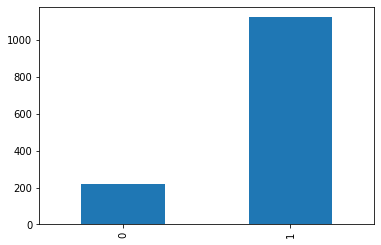

In [7]:
labeled_data.rateable.value_counts(sort=False).plot(kind="bar")

-> we have imbalanced (and generally too less) data.

## Binary Classification

ML-based approach.

### Train/Test-Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(labeled_data.cleaned_txt, labeled_data.rateable,
                                                    test_size=0.15, random_state=random_state)

print("X shapes (train/test):", X_train.shape, "/", X_test.shape)
print("y shapes (train/test):", y_train.shape, "/", y_test.shape)

X shapes (train/test): (1140,) / (202,)
y shapes (train/test): (1140,) / (202,)


### Vectorizer

In [9]:
tfidf = TfidfVectorizer(lowercase=False, # already lowercased
                        tokenizer=word_tokenize,
                        ngram_range=(1,2),
                        max_features=10000) # tune max_features for generalization eventually

### Models

In [10]:
logreg = LogisticRegression(random_state=random_state, n_jobs=-1)
#lasso = LassoCV(random_state=random_state, n_jobs=-1)
#svc = LinearSVC(random_state=random_state)
nb = MultinomialNB()
#rf = RandomForestClassifier(random_state=random_state, n_jobs=-1)

models = [logreg, nb]

Parameters

In [11]:
params = {}
params["LogisticRegression"] = {"penalty": ["l1", "l2"],
                                "C": [0.01, 0.1, 1., 10.,30., 60.],
                                "class_weight": ["balanced"]}
params["LassoCV"] = {"eps": [0.0001, 0.001, 0.01],
                     "normalize": [False, True]}
params["LinearSVC"] = {"C": [0.01, 0.1, 1., 10., 20.],
                       "class_weight": [None, "balanced"]}
params["MultinomialNB"] = {"alpha": [0., 1.],
                           "fit_prior": [True, False]}
params["RandomForestClassifier"] = {"n_estimators": [2, 32, 64, 128],
                                    "criterion": ["gini", "entropy"],
                                    "min_samples_leaf": [1, 2],
                                    "max_features": [None, "auto"],
                                    "class_weight": [None, "balanced"]}

### Pipeline

In [12]:
classifiers = {}

for model in models:
    classifiers[type(model).__name__ + "_pipe"] = Pipeline([
        ("tfidf", tfidf),
        ("clf", GridSearchCV(model, param_grid=params[type(model).__name__],
                             scoring="balanced_accuracy", cv=8, refit=True, n_jobs=-1))
    ])

Train

In [13]:
for _, clf_pipeline in classifiers.items():
    clf_pipeline.fit(X_train, y_train)

/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Predict

In [14]:
best_acc = 0
best_model_pipe = None

for name, clf_pipeline in classifiers.items():
    y_pred = clf_pipeline.predict(X_test)
    acc = balanced_accuracy_score(y_test, y_pred)
    print(acc, name, clf_pipeline.named_steps["clf"].best_params_, clf_pipeline.named_steps["clf"].best_score_)
    
    if acc > best_acc:
        best_model_pipe = clf_pipeline
        best_acc = acc

0.5926573426573426 LogisticRegression_pipe {'C': 1.0, 'class_weight': 'balanced', 'penalty': 'l1'} 0.6422484069304201
0.5327797202797203 MultinomialNB_pipe {'alpha': 1.0, 'fit_prior': False} 0.6263079429214445


In [15]:
#len(best_model_pipe.named_steps["tfidf"].get_feature_names())

## Evaluation

In [16]:
class_encoding = {0: "non-rateable", 1: "rateable"}

#### Confusion Matrix

/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


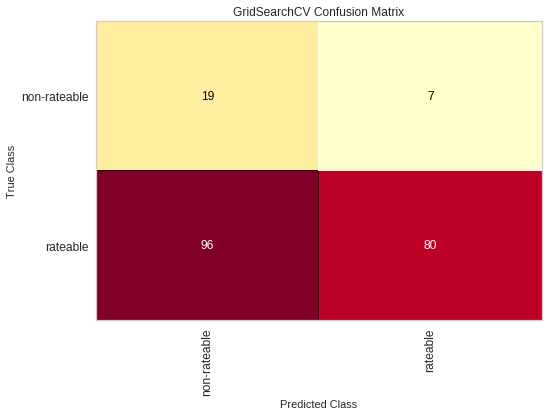

In [17]:
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, PrecisionRecallCurve, ROCAUC

cm = ConfusionMatrix(best_model_pipe, is_fitted=True, encoder=class_encoding)
cm.score(X_test, y_test)
cm.poof()

#### Classification Report

              precision    recall  f1-score   support

           0       0.17      0.73      0.27        26
           1       0.92      0.45      0.61       176

    accuracy                           0.49       202
   macro avg       0.54      0.59      0.44       202
weighted avg       0.82      0.49      0.56       202



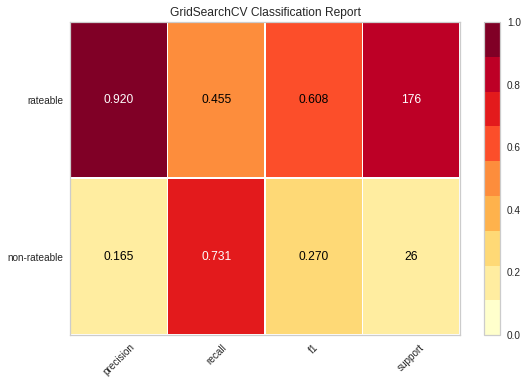

In [18]:
print(classification_report(y_test, best_model_pipe.predict(X_test)))

# Visualizer
report = ClassificationReport(best_model_pipe, is_fitted=True, encoder=class_encoding, support=True)
report.score(X_test, y_test)
report.poof()

#### Precision-Recall Curve

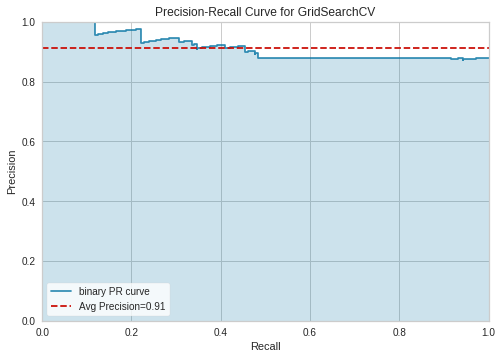

In [19]:
pr_curve = PrecisionRecallCurve(best_model_pipe)
pr_curve.fit(X_train, y_train)
pr_curve.score(X_test, y_test)
pr_curve.poof()

#### ROCAUC

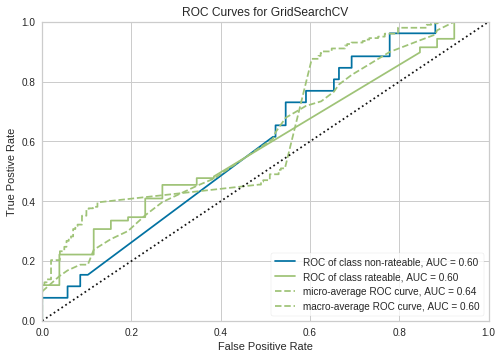

In [20]:
rocauc = ROCAUC(best_model_pipe, is_fitted=True, encoder=class_encoding)
rocauc.score(X_test, y_test)
rocauc.poof()

# Conclusion

#FIXME